# Gaussian Imputation

In [1]:
try:
    import jax.numpy as jnp
    from jax import random
except:
    %pip install jax jaxlib
    import jax.numpy as jnp
    from jax import random

try:
    import matplotlib.pyplot as plt
except:
    %pip install matplotlib
    import matplotlib.pyplot as plt

try:
    from scipy.stats import t, laplace, norm
except:
    %pip install scipy
    from scipy.stats import t, laplace, norm

try:
    import seaborn as sns
except:
    %pip install seaborn
    import seaborn as sns

try:
    from sklearn.datasets import make_spd_matrix
except:
    %pip install sklearn
    from sklearn.datasets import make_spd_matrix

In [2]:
import sys

# Don't change to "../scripts", instead, run this nb from repo's root with ipython
sys.path.append("scripts")
import gauss_utils as gauss
import pyprobml_utils as pml

import os

LATEXIFY = "LATEXIFY" in os.environ

if LATEXIFY:

    from plot_utils import latexify, savefig

    latexify(width_scale_factor=2, fig_height=3, font_size=14)

In [3]:
def plot_hinton_data(data, title, save_name=""):
    """
    Draw a hinton plot

    Args:
    ----------
    data : JAX array
        Data for the hinton graph

    title : string
        Title for graph

    save_name :  string, default=''
        Filename for the saved graph

    Returns:
    ----------
    None
    """

    plot = plt.figure()
    pml.hinton_diagram(data, ax=plot.gca())
    plt.title(title)
    plt.ylabel("Dimension of Data")
    plt.xlabel("Number of samples")

    # Save figure to PDF files
    if LATEXIFY and len(save_name) > 0:
        savefig(save_name)

    plt.show()

In [4]:
def gen_imputer_data(data_dim=8, sample_size=10, threshold_missing=0.5):
    """
    Sample from a multivariate normal distribution generated using random
    mean and covariance. Then after randomly removing the values from the
    matrix update them using a gaussian imputer.

    Args:
    ----------
    data_dim : int,deafult=7
        The PDF filenames to save the graphs

    sample_size : int, default=10
        Changes position of outliers

    threshold_missing :  float, default=0.5
        A list of outlier values

    Returns:
    ----------
    None
    """

    # Generate Mean for Mulivariate gaussian
    mean = random.normal(random.PRNGKey(42), shape=(data_dim, 1))

    # Generate a random positive definite matrix i.e covariance matrix
    cov = make_spd_matrix(n_dim=data_dim)

    # Test if the matrix is positive definite
    if not gauss.is_pos_def(cov):
        print(f"The covariance matrix is not positive definite. \n {cov}")
        return None

    # The ground truth or hiddden truth
    x_full = gauss.gauss_sample(mean, cov, sample_size)

    # Randomly adding nan values to ground truth for imputation
    missing_idx = random.normal(random.PRNGKey(53), shape=(sample_size, data_dim)) < threshold_missing
    x_miss = jnp.copy(x_full)
    x_miss = x_miss.at[missing_idx].set(jnp.nan)

    # Imputing missing/nan values we created above
    x_imputed = gauss.gauss_impute(mean, cov, x_miss)

    # This is for plotting, nan values cannot be plotted, hence replacing them with zeros
    x_miss0 = jnp.copy(x_full)
    x_miss0 = x_miss0.at[missing_idx].set(0)

    # Plot the data
    plot_hinton_data(x_miss0, "Observed", "gauss_impute_observed.pdf")
    plot_hinton_data(x_full, "Hidden truth", "gauss_impute_truth.pdf")
    plot_hinton_data(x_imputed, "Imputation True Parameter", "gauss_impute_pred.pdf")

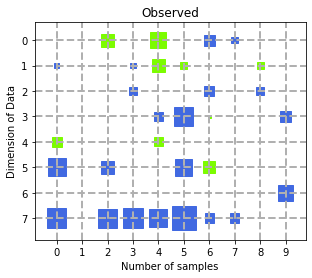

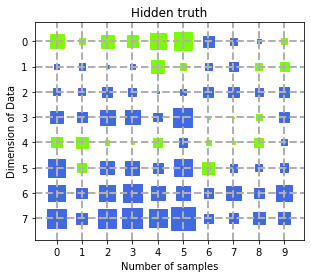

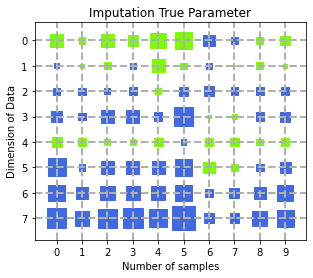

In [5]:
gen_imputer_data()

In [6]:
from ipywidgets import interact
import ipywidgets as widgets


@interact(
    data_dim=widgets.IntSlider(description="data_dim", min=5, max=15, value=10, continuous_update=False),
    sample_size=widgets.IntSlider(description="sample_size", min=5, max=15, value=10, continuous_update=False),
    threshold_missing=widgets.FloatSlider(
        description="threshold_missing",
        min=0,
        max=1,
        value=0.5,
        step=0.1,
        continuous_update=False,
    ),
)
def update(data_dim, sample_size, threshold_missing):
    gen_imputer_data(data_dim=data_dim, sample_size=sample_size, threshold_missing=threshold_missing)

interactive(children=(IntSlider(value=10, continuous_update=False, description='data_dim', max=15, min=5), Int…